In [1]:
# This first block I have just used in colab
# ## If you are running on Google Colab, uncomment below to install the necessary dependencies 

# print("Setting up colab environment")
# !pip uninstall -y -q pyarrow
# !pip install -q -U ray[tune]
# !pip install -q ray[debug]
# !pip install ruamel.yaml

# # A hack to force the runtime to restart, needed to include the above dependencies.
# print("Done installing! Restarting via forced crash (this is not an issue).")
# import os
# os._exit(0)

In [2]:
## If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x


In [1]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
import ray
from ray import tune
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
import shutil
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [5]:
class dependent_bandit():
    def __init__(self, difficulty):
        self.num_actions = 2
        self.n_timesteps = 100
        self.difficulty = difficulty
        self.reset()
        
    def set_restless_prob(self):
        self.bandit = np.array([self.restless_list[self.timestep],1 - self.restless_list[self.timestep]])
        
    def reset(self):
        self.timestep = 0
        if self.difficulty == 'restless': 
            variance = np.random.uniform(0,.5)
            self.restless_list = np.cumsum(np.random.uniform(-variance,variance,(150,1)))
            self.restless_list = (self.restless_list - np.min(self.restless_list)) / (np.max(self.restless_list - np.min(self.restless_list))) 
            self.set_restless_prob()
        if self.difficulty == 'easy': 
            bandit_prob = np.random.choice([0.9,0.1])
        if self.difficulty == 'trivial': 
            bandit_prob = np.random.choice([1.0,0.0])
        if self.difficulty == 'medium': 
            bandit_prob = np.random.choice([0.75,0.25])
        if self.difficulty == 'hard':  
            bandit_prob = np.random.choice([0.6,0.4])
        if self.difficulty == 'uniform': 
            bandit_prob = np.random.uniform()
        if self.difficulty != 'independent' and self.difficulty != 'restless':
            self.bandit = np.array([bandit_prob,1 - bandit_prob])
        else:
            self.bandit = np.random.uniform(size=2)
        
    def step(self,action):
        #Get a random number.
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[int(action)]
        result = np.random.uniform()
        if result < bandit:
            #return a positive reward.
            reward = 1
        else:
            #return a negative reward.
            reward = 0
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        return reward, done, self.timestep

In [6]:
class GaussBandit(dependent_bandit):
    """
    creates a dependent bandit that gives a reward normally distributed around some mean
    the mean values are the same as for the dependent bandit class. 
    variance is set to 0.5 as standard but can be changed using the keyword scale
    
    Sidenote:
    This is really just an experiment I made. I wanted to see whether learning on
    the standard dependent_bandit would have any effect in this environment and vice 
    versa. I did not get around to test and train agents in this environment after all
    but I found it interesting that agents trained on the standard dependent_bandit
    actually performed better than random in this environment
    """
    def __init__(self, difficulty, scale = 0.5):
        super().__init__(difficulty)
        self.scale = scale
        
    def step(self, action):
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[int(action)]
        reward = stats.norm.rvs(loc=bandit, scale=self.scale)
        
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        
        return reward, done, self.timestep
        
g = GaussBandit('easy')
print(g.bandit)
g.step(1)

[0.1 0.9]


(1.5730627001754955, False, 1)

In [7]:
class ThompsonAgent:
    """
    Creates an agent that plays the dependent_bandit using thompson sampling.
    The agent behaves pretty much like the lstm Agent class later

    To get it to play through an environment you can use the play method
    this returns  the history of actions, rewards, beta-values and estimated mean-values

    I did not get this to work with the Benchmark class but I added a benchmark method to the class
    """
    def __init__(self, env_name):
        self.env = dependent_bandit(env_name)
        self.reset()
    
    def reset(self):
        self.pulls = np.zeros(2)
        #sampled mean of an arm
        self.mean = np.zeros(2)
        #beta for use in thompson sampling
        self.beta = np.ones((2,2))
        self.env.reset()
    
    def pull(self, arm):
        self.pulls[arm] += 1
        r, done, timestep = self.env.step(arm)
        self.update_mean(arm, r)
        self.update_beta(arm, r)
        return r, done, timestep
    
    def update_mean(self, arm, r):
        n = self.pulls[arm]
#         m = self.mean[arm]
        self.mean[arm] = (n-1)/n*self.mean[arm] + r/n
    
    def update_beta(self, arm, r):
        self.beta[arm] += np.array([r, 1-r])
    
    def change_env(self, env):
        self.env = env
        self.reset()
    
    def predict(self):
        return np.argmax([np.random.beta(self.beta[0][0], self.beta[0][1]), np.random.beta(self.beta[1][0], self.beta[1][1])])
    
    def play(self, n):
        self.reset()
        r_hist = np.empty(n)
        a_hist = np.empty(n)
        mean_hist = np.empty((2,n+1))
        mean_hist[:,0] = self.mean
        beta_hist = np.empty((2, n+1, 2))
        beta_hist[:,0,:] = self.beta
        for i in range(n):
            j = self.predict()
            a_hist[i] = j
            r_hist[i], _, _ = self.pull(j)
            beta_hist[:,i+1,:] = self.beta
            mean_hist[:,i+1] = self.mean
        return a_hist, r_hist, beta_hist, mean_hist

    def benchmark(self, n_episodes = 300, n_timesteps = 100):
        #for now n_timesteps will be 100 since that is the value in the dependent env
        actions = np.empty((n_episodes, n_timesteps))
        rewards = np.empty((n_episodes, n_timesteps))
        bandits = np.empty((n_episodes, 2))
        for i in range(n_episodes):
            a, r, _, _ = self.play(n_timesteps)
            bandits[i] = self.env.bandit
            actions[i] = a
            rewards[i] = r
        return {'actions': actions, 'rewards': rewards, 'env': self.env, 'bandits': bandits}

In [8]:
class GaussThompson:
    """
    Basically the same as the other thompson except it works on the GaussBandit
    """
    def __init__(self, env_name, tau = 1):
        self.env = GaussBandit(env_name)
        self.tau = tau
    
    def reset(self):
        self.pulls = np.zeros(2)
        self.mean = np.zeros(2)
        self.lambd = np.ones(2)
        self.env.reset()
        
    def pull(self, arm):
        self.pulls[arm] += 1
        r, done, timestep = self.env.step(arm)
        self.update_variables(arm, r)
        return r, done, timestep

    def update_variables(self, arm, r):
        self.mean[arm] = 1/(self.tau*self.pulls[arm]+1)*(self.tau*r + (self.tau*(self.pulls[arm]-1)+1)*self.mean[arm])
        self.lambd[arm] = self.tau + self.lambd[arm]
    
    def predict(self):
        return np.argmax([np.random.normal(self.mean[0], np.sqrt(1/self.lambd[0])), np.random.normal(self.mean[1], np.sqrt(1/self.lambd[1]))])
    
    def play(self, n):
        self.reset()
        r_hist = np.empty(n)
        a_hist = np.empty(n)
        mean_hist = np.empty((2,n+1))
        mean_hist[:,0] = self.mean
        lambda_hist = np.empty((2, n+1))
        lambda_hist[:,0] = self.lambd
        for i in range(n):
            action = self.predict()
            a_hist[i] = action
            r_hist[i], _, _ = self.pull(action)
            lambda_hist[:,i+1] = self.lambd
            mean_hist[:,i+1] = self.mean
        return a_hist, r_hist, lambda_hist, mean_hist

    def benchmark(self, n_episodes = 300, n_timesteps = 100):
        #for now n_timesteps will be 100 since that is the value in the dependent env
        actions = np.empty((n_episodes, n_timesteps))
        rewards = np.empty((n_episodes, n_timesteps))
        bandits = np.empty((n_episodes,2))
        for i in range(n_episodes):
            a, r, _, _ = self.play(n_timesteps)
            bandits[i] = self.env.bandit
            actions[i] = a
            rewards[i] = r
        return {'actions': actions, 'rewards': rewards, 'env': self.env, 'bandits': bandits}

array([0.57670146, 0.42329854])

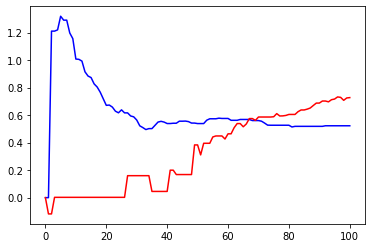

In [9]:
gauss = GaussThompson('restless')
a,  r, l, m = gauss.play(100)
plt.plot(m[0], 'b')
plt.plot(m[1], 'r')
gauss.env.bandit

In [10]:
bandit = dependent_bandit('uniform')

In [11]:
bandit.reset()

In [12]:
bandit.step(0)

(1, False, 1)

In [13]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=4, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
        self.policy = kl.Dense(
            num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        inputs = tf.cast(inputs, dtype=tf.float32)
#         print(inputs)
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value 

In [14]:
env = dependent_bandit('uniform')

In [15]:
# Verify everything works by sampling two actions.

model = Model(env.num_actions)

action = 0
reward, timestep = 0, 0
# reward, done, timestep = env.step(action)
action = tf.one_hot(action, 2)
observation = tf.concat([
        [[reward],[reward]], 
        [action, action],
        [[timestep], [timestep]]], 1)
observation = tf.expand_dims(observation, [1])
# print(observation)
action, value = model.predict_action_value(observation)
print(action, value)
# print(action.shape, value.shape)

tf.Tensor([0 1], shape=(2,), dtype=int64) tf.Tensor([0.06559491 0.11440822], shape=(2,), dtype=float32)


In [16]:
# Verify everything works by sampling two actions with state reset.
env = dependent_bandit('uniform')
model = Model(env.num_actions)

action = 0
for _ in range(2):
    print(model.lstm.states)
    reward, done, timestep = env.step(action)
    action = tf.one_hot(action, 2)
    observation = tf.concat([
        [[reward]], 
        [action],
        [[timestep]]], 1)
    observation = tf.expand_dims(observation, [1])

    action, value = model.predict_action_value(observation)
    # print(action, value)
#     model.lstm.reset_states()
    action = np.squeeze(action)


[<tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>]
[<tf.Variable 'Variable:0' shape=(1, 48) dtype=float32, numpy=
array([[-1.1290785e-02,  4.7634537e-03,  4.3167458e-03,  1.8553065e-02,
        -9.6491014e-05, -4.6801403e-02, -1.7941374e-03,  3.0309452e-02,
         4.1844387e-02, -1.9194884e-02, -3.7627000e-02,  4.3088421e-03,
        -4.9549047e-02,  3.1640939e-02,  3.8462677e-03,  1.9411439e-02,
        -3.2133397e-02,  3.4895822e-02,  1

In [17]:
class Agent:
    """
    have not changed much here, the storage of the data_path is changed slightly
    to get it working with tune

    I have set the run_episode to also return the environment for use in calculating different values
    this is mainly used in the RayAgent class later
    """
    def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.instance = instance
        if instance == 'bernoulli':
            self.env = dependent_bandit(env_name)
        elif instance == 'gauss':
            self.env = GaussBandit(env_name)
        self.name = name or 'a2c_agent_env_' + env_name
        self.model = model(env.num_actions, batch_size=1, name=self.name)
        # Define separate losses for policy logits and value estimate.
        # the storage of the data_path is changed slightly here don't know if it matters?
        self.data_path = (data_path or Path().cwd()) / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '.npy', self.training_history)
        self.model.save_weights(str(self.data_path / self.name))
        
    def load_agent(self):
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        self.training_history = np.load(str(self.data_path / self.name) + '.npy')
        self.model.load_weights(str(self.data_path / self.name))
        self.__dict__.update(self.parameters)
        self._compile()
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        try:
            self.training_history = self.training_history
        except:
            self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, rewards, values, observations, env = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)

            accuracy = (actions == np.argmax(env.bandit)).mean()
            
            losses = self.model.train_on_batch(observations, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self, env=None):
        env = env or self.env

        env.reset()
        # Storage helpers for a single batch of data.
        actions = np.empty((env.n_timesteps,), dtype=np.int32)
        rewards, values = np.empty((2, env.n_timesteps))
        observations = np.empty((env.n_timesteps, 1, 4))
        
        self.model.reset_states()
        action, reward, timestep, done, step = 0, 0, 0, 0, 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, observations[step] = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            # rewards, values and actions at t
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, rewards, values, observations, env
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss

In [18]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)


agent = Agent(Model, env_name='restless')

_, rewards, _, _, _ = agent.run_episode()
print(sum(rewards))

58.0


# Implement Ray[tune]

In [21]:
# trying to implement ray[tune]
# based on this tutorial: https://medium.com/riselab/cutting-edge-hyperparameter-tuning-with-ray-tune-be6c0447afdf
# and this notebook: https://colab.research.google.com/github/ray-project/tutorial/blob/master/tune_exercises/exercise_1_basics.ipynb

# this is as done in the notebook above but with more values reported
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch and reports different values to tune
    these values can be used for early stopping in training if they are too low or high
    They can also be used for optimisation.
    See 'Analysis block' a bit below.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs,
                    loss=logs.get("loss"),
                    accuracy = logs.get('accuracy'),
                    mean_reward = logs['mean_reward'],
                    late_regret = logs['late_regret'],
                    running_loss = logs['running_loss'])


class RayAgent(Agent):
    """
    Agent to be used with tune. Mostly the same as the standard Agent.
    The agent reports different values to tune via the TuneReporterCallback()
    It also saves the agent with lowest loss as a 'checkpoint'. This was my 
    way of doing a ModelCheckpoint as in the notebook linked above
    but it might be a bad idea...

    In the training loop this agent also calculates the regret and accuracy of each episode
    and calculates the average loss of of all episodes as it goes. This is in case it could
    be useful for updating hyperparameters and utilising early stopping.
    """
    def __init__(self, model, env_name, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name=None, data_path=None, instance = 'bernoulli'):
        super().__init__(model, env_name, learning_rate, gamma, value_coefficient, entropy_coefficient, name, data_path, instance)
        # did not get the 'ModelCheckpoint' -way to work as in the tutorial
        # self.modelcheckpoint = ModelCheckpoint("model.h5", monitor='loss', save_best_only=True, save_freq='epoch')
        # self.modelcheckpoint.set_model(self.model)
        self.tunereporter = TuneReporterCallback()
        self.tunereporter.set_model(self.model)
        
    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.

        #set it like this in case you train a model and want to train it further.
        try:
            self.training_history = self.training_history
        except:
            self.training_history = []

        # set a value for previous loss, use this to save agents that have a lower loss-function
        previous_loss = 1E10 #start with a really high value

        #calculate runninng mean of loss, if the loss converges to some value then 
        # so should the running loss (obviously not the other way though)
        running_loss = 0

        for episode in tqdm(range(episodes)):
            actions, rewards, values, observations, env = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(observations, [actions_advantages, returns])

            # self.modelcheckpoint.on_epoch_end(episode, {'loss':losses[0]}) #did not get this working

            # save agent if loss is lower than current best agent, might not be smart..
            if abs(losses[0]) < previous_loss:
                self.save_agent()

            previous_loss = abs(losses[0])

            #get accuracy of episode
            equals = actions == np.argmax(env.bandit)
            accuracy = equals.mean()

            # the formula for updating the running mean
            running_loss = (losses[0] + running_loss*(episode))/(episode + 1)

            #regret of an episode
            regret = env.bandit.max() - equals*env.bandit.max()-np.invert(equals)*env.bandit.min()

            #report to tune
            self.tunereporter.on_epoch_end(episode, {'loss': losses[0],
                                                     'mean_reward': rewards.mean(), 
                                                     'accuracy':accuracy, 
                                                     'late_regret': np.sum(regret[-20:]),
                                                     'running_loss': running_loss})
            
            # self.model.save(f'model{episode}') #this is done above instead but might be better this way?
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        # self.modelcheckpoint.on_train_end(None)
        self.tunereporter.on_train_end(None) #as in the tutorial don't know why
        return self.training_history

def load_ray_agent(logdir,env, name = None):
    """
    loads a RayAgent from it's data_path and name
    again note that the storage of self.data_path has been changed slightly in the Agent class
    """
    data_path = Path(logdir)
    if name == None:
        a = RayAgent(Model, env_name = env, data_path = data_path)
    else:
        a = RayAgent(Model, env_name = env, name = name, data_path = data_path)
    a.load_agent()
    return a




In [22]:
# trying to implement ray[tune]
def tune_agent(config):
    """
    Creates and trains a RayAgent according to some config dictionary. 
    This function is passed to tune.run along with the config and some other
    parameters, see 'Analysis block' below
    """
    agent = RayAgent(Model, env_name = config['env'], learning_rate = config['lr'], gamma=config['gamma'], entropy_coefficient= config['ec'], value_coefficient=config['vc'])
    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    agent.train(config['episodes'])
    
ray.shutdown()

In [28]:
# Analysis block
from ray.tune.schedulers import ASHAScheduler
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

# The schedulders implement early stopping and the ray.tune.suggest are search algorithms
# for choices of hyperparameters. I used HyperOptSearch since it was used in following
# tutorial: https://docs.ray.io/en/latest/tune/tutorials/tune-tutorial.html
# documentation for schedulers: https://docs.ray.io/en/latest/tune/api_docs/schedulers.html#tune-schedulers
# documentation for search algorithms: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#tune-search-alg

# first a config for HyperOptSearch
# here the values can certainly be optimised

# config = {
#     'lr': hp.loguniform('lr', np.log(0.00001), np.log(0.01)),
#     'gamma': hp.uniform('gamma',0.5,1),
#     'env': 'hard',
#     'vc': hp.uniform('vc', 0.5,1),
#     'ec': hp.uniform('ec', 0,0.05),
#     'episodes': 10000
# }

# a config for grid_search, again the values used can be chosen better.
config = {
    'lr': tune.grid_search([0.00794201513518785, 0.010071661229025614, 0.003150087597448177]),
    'gamma': tune.grid_search([0.46736200545385154, 0.662083596501603, 0.7315445113967135]),
    'env': 'hard',
    'vc': tune.grid_search([0.10471441019892447, 0.34740422443753005, 0.3151379752524732]),
    'ec': tune.grid_search([0.0013220638509968284, 0.00024305803762718193, 0.003078870214204114]),
    'episodes': 10000
}

# a search optimiser
hyperopt_search = HyperOptSearch(config, metric = "loss", mode="min")
# obviously env and episodes are not hyperparameters but I just put them in there to update all in one go.
num_samples = 100


####################################################################################################
################ This is just a validation function for tutorial purposes only. ####################
HP_KEYS = ["lr", "gamma", "env", 'vc', 'ec']
assert all(key in config for key in HP_KEYS), (
    "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
######################################################################################################

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
# this line is obviously 'dangerous' and might be smart to remove later on.
! rm -rf ~/ray_results/tune_agent

# here the values can for sure be picked better as well
scheduler = ASHAScheduler(metric= 'running_loss', 
                          mode = 'min', grace_period = 10, 
                          brackets=1, reduction_factor =2, 
                          max_t = config['episodes'])

# the analysis returns a dataframe with values reported to tune
# and hyperparameters of agents
analysis = tune.run(
    tune_agent, 
    verbose=1, 
    config=config,
    # search_alg = hyperopt_search,
    scheduler = scheduler)
    #num_samples=num_samples)


Trial name,status,loc,ec,gamma,lr,vc,loss,iter,total time (s)
tune_agent_hard_ee786_00000,TERMINATED,,0.00132206,0.467362,0.00794202,0.104714,-0.156282,10,11.8147
tune_agent_hard_ee786_00001,TERMINATED,,0.000243058,0.467362,0.00794202,0.104714,0.10166,2560,1749.06
tune_agent_hard_ee786_00002,TERMINATED,,0.00307887,0.467362,0.00794202,0.104714,-0.269961,10000,6640.91
tune_agent_hard_ee786_00003,TERMINATED,,0.00132206,0.662084,0.00794202,0.104714,0.0366356,20,18.7844
tune_agent_hard_ee786_00004,TERMINATED,,0.000243058,0.662084,0.00794202,0.104714,-0.218359,10,11.5936
tune_agent_hard_ee786_00005,TERMINATED,,0.00307887,0.662084,0.00794202,0.104714,-0.201046,5120,3295.86
tune_agent_hard_ee786_00006,TERMINATED,,0.00132206,0.731545,0.00794202,0.104714,-0.119722,10,10.6589
tune_agent_hard_ee786_00007,TERMINATED,,0.000243058,0.731545,0.00794202,0.104714,0.166836,10,10.4787
tune_agent_hard_ee786_00008,TERMINATED,,0.00307887,0.731545,0.00794202,0.104714,-0.428138,10,10.4208
tune_agent_hard_ee786_00009,TERMINATED,,0.00132206,0.467362,0.0100717,0.104714,0.0203021,20,17.1929


In [ ]:
print("You can use any of the following columns to get the best model: \n{}.".format(
    [k for k in analysis.dataframe() if k.startswith("keras_info")]))
print("=" * 10)

# this should be the directory of the best agent (regarding loss)
# but I'm not 100% coonvinced since I might have a bug
logdir = analysis.get_best_logdir("keras_info/loss", mode="min")

# load the agent from the logdir
agent = load_best_agent(logdir, 'hard')

You can use any of the following columns to get the best model: 
['keras_info/loss', 'keras_info/mean_reward'].
/root/ray_results/tune_agent/tune_agent_hard_6_ec=0.086036,gamma=0.64266,lr=0.0040487,vc=0.65114_2020-08-13_12-34-40o4cnf3py


In [ ]:
# from here just playing around again
print(agent.entropy_coefficient)
print(agent.value_coefficient)
print(agent.learning_rate)
print(agent.gamma )

0.003078870214204114
0.3151379752524732
0.003150087597448177
0.7315445113967135


In [ ]:
df = analysis.dataframe()
np.abs(df['mean_loss'])
# df.sort_values(by=['keras_info/loss'])
# np.abs(df['keras_info/loss'])

0     4.487146
1     0.052100
2     0.260175
3     0.174216
4     0.201002
5     2.054963
6     0.144058
7     0.843013
8     0.128974
9     0.693586
10    0.104266
11    0.184015
12    1.364127
13    0.141782
14    0.024776
15    1.201749
16    0.077754
17    0.128224
18    0.221034
19    0.105955
Name: mean_loss, dtype: float64

In [ ]:
log16 = Path('/root/ray_results/tune_agent/tune_agent_hard_16_ec=0.0030789,gamma=0.73154,lr=0.0031501,vc=0.31514_2020-08-13_05-18-55zw48s1if')
agent = load_best_agent(log1, 'hard')

Hyperparams to try:
 ec: 0.0013220638509968284
 vc: 0.10471441019892447
 lr: 0.00794201513518785
 gamma: 0.46736200545385154

ec: 0.00024305803762718193
vc: 0.34740422443753005
lr: 0.010071661229025614
gamma: 0.662083596501603

ec: 0.003078870214204114
vc: 0.3151379752524732
lr: 0.003150087597448177
gamma: 0.7315445113967135

[0.0013220638509968284, 0.00024305803762718193, 0.003078870214204114]


# train

In [21]:
# for e in ['easy', 'medium', 'hard', 'uniform']:
name = "easygauss"
agent = Agent(Model, 'easy', name = name, instance = 'gauss')
agent.train(20000)
agent.save_agent()
del agent
  

# training_history = agent.train(20000)

# print("Finished training! Testing...")
# print("Total Episode Reward: %d out of 100" % agent.run_episode()[1].sum())

In [19]:
agent = Agent(Model, 'easy', name = 'easygauss', instance = 'gauss')

# or load weights

In [ ]:
agent.save_agent()

In [20]:
agent.load_agent()

In [ ]:
agent.training_history
# plt.style.use('seaborn')
# plt.plot(np.arange(0, len(agent.training_history), 5), agent.training_history[::5])
# # plt.plot(np.arange(len(training_history)), training_history)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')

array([43., 60., 50., ..., 53., 66., 55.])

# analyze model

In [19]:
class Benchmark:
    """
    here regret is added for uniform as well
    """
    def __init__(self, agent, env_name=None, n_episodes=300, instance = 'bernoulli'):
        self.agent = agent
        self.env_name = env_name or agent.env_name
        self.instance = instance
        if instance == 'bernoulli':
            self.env = dependent_bandit(self.env_name)
        elif instance == 'gauss':
            self.env = GaussBandit(self.env_name)
        self.n_episodes = n_episodes
    
    def evaluate(self):
        rewards = np.empty((self.n_episodes, self.env.n_timesteps))
        actions = np.empty((self.n_episodes, self.env.n_timesteps))
        values = np.empty((self.n_episodes, self.env.n_timesteps))
        bandits = np.empty((self.n_episodes, 2))
        for episode in tqdm(range(self.n_episodes)):
            actions[episode], rewards[episode], values[episode], _, _ = self.agent.run_episode(self.env)
            bandits[episode] = self.env.bandit
        self.episodes = {
            'rewards': rewards,
            'actions': actions,
            'values': values,
            'bandits': bandits
        }
            
    def hist(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        plt.hist(self.episodes['rewards'].sum(1) / (self.env.bandit.max() * 100))

    def calculate_regret(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        
        #implement regret for 'uniform' environment
        if self.env.difficulty == 'uniform':
            arr = np.empty(self.episodes['rewards'].shape).T
            arr[:,:] = np.max(self.episodes['bandits'], axis = 1)
            regret = (arr.T - self.episodes['rewards']).mean(0)
        else:
            regret = self.env.bandit.max() - self.episodes['rewards'].mean(0)
        return regret
  
    def plot_cumulative_regret(self):
        plt.plot(np.cumsum(self.calculate_regret()))
        
    def plot_rewards(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()

        im = plt.imshow(self.episodes['rewards'], cmap='binary', origin='lower', interpolation='nearest')
        
#         patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
#         plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)
    
    def plot_actions(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()
        actions_optimal = np.empty_like(self.episodes['actions'])
        _itr = zip(self.episodes['actions'], np.argmax(self.episodes['bandits'], 1))
        
        for i, (actions_episode, optimal_choice) in enumerate(_itr):
            actions_optimal[i] = actions_episode == optimal_choice

        im = plt.imshow(actions_optimal, cmap='Greens_r', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)

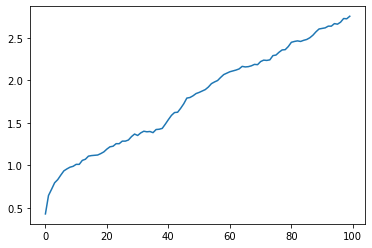

In [55]:

# b = Benchmark(agent, 'easy')
# b.plot_cumulative_regret()
# b = agent.benchmark()
agent = Agent(Model, 'easy', name = 'easygauss')
agent.load_agent()
b1 = Benchmark(agent, 'easy')
reg1 = b1.calculate_regret()
plt.plot(np.cumsum(reg1))


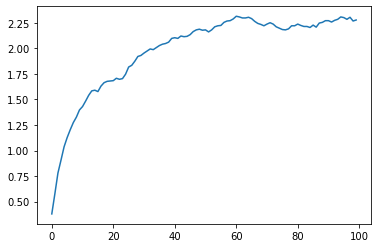

In [56]:
g = ThompsonAgent('easy')
b2 = g.benchmark()
treg = np.max(b2['bandits']) - b2['rewards'].mean(axis = 0)
plt.plot(np.cumsum(treg))

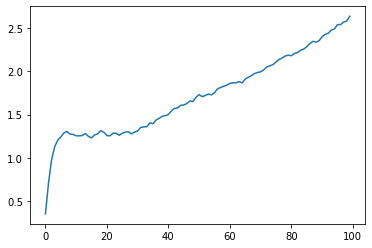

In [59]:
# treg = np.max(b2['bandits']) - b2['rewards'].mean(axis = 0)
a2 = Agent(Model, 'easy')
a2.load_agent()
b3 = Benchmark(a2, 'easy')
reg2 = b3.calculate_regret()
# np.max(b2['bandits'], axis = 1)
plt.plot(np.cumsum(reg2))

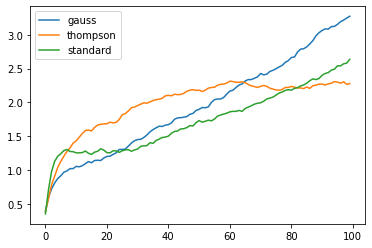

In [61]:
bernoulli_df = pd.DataFrame()
bernoulli_df['gauss'] = np.cumsum(reg)
bernoulli_df['thompson'] = np.cumsum(treg)
bernoulli_df['standard'] = np.cumsum(reg2) 
bernoulli_df.plot()

In [62]:
bernoulli_df.to_csv('bernoulli_df.csv')

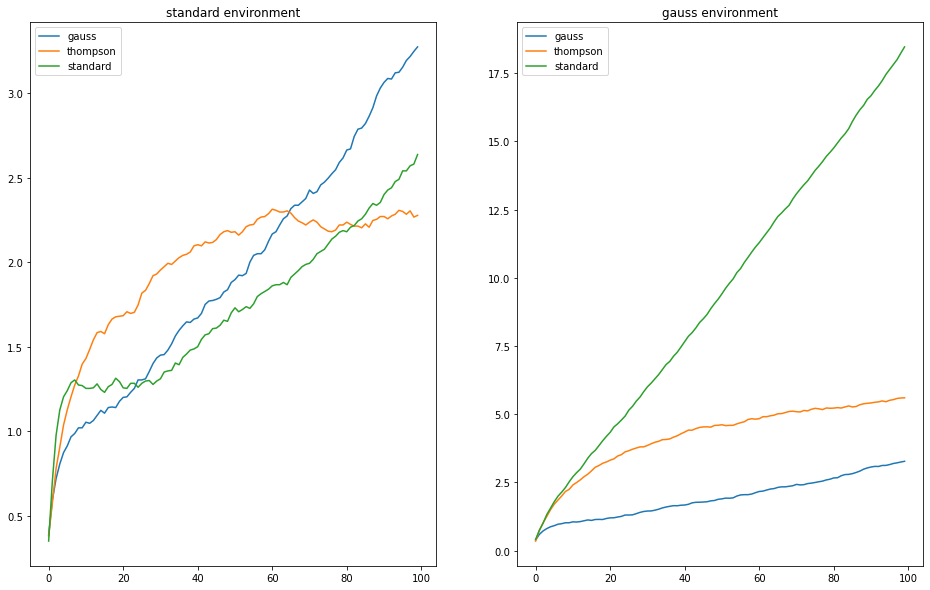

In [72]:
# plt.figure(figsize = (12,12))
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,10))
axes[0].set_title('standard environment')
axes[1].set_title('gauss environment')
bernoulli_df.plot(ax = axes[0])
gauss_df.plot(ax = axes[1])
plt.savefig('bandits in standard and gaus env')
# plt.subplot(121)
# bernoulli_df.plot()
# plt.subplot(122)
# gauss_df.plot()


In [30]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [31]:
! cp -a ~/ray_results ./drive/'My Drive'/ML/sommer2020/ray/ray2
# b = Benchmark(agent, 'easy')
# b.evaluate()
# ! ./content

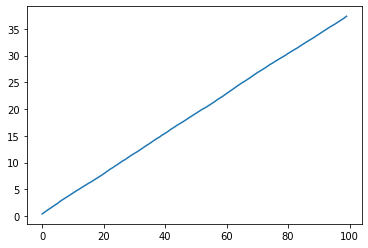

In [ ]:
b.plot_cumulative_regret()


In [ ]:
# a2 = Agent(Model, 'easy')
# a2.train(1000)
b2 = Benchmark(a2, 'easy')
b2.plot_cumulative_regret()

NameError: ignored

In [ ]:
r1 = b.calculate_regret()
# r2 = b2.calculate_regret()
print(f"r1 = {np.cumsum(r1)[-1]:.2f}")

r1 = 10.44


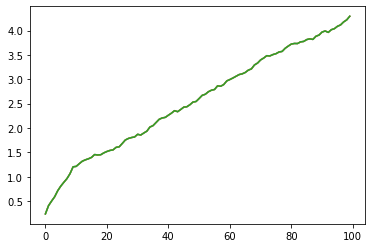

In [ ]:

# cum_regret = {}

arr = np.empty(b.episodes['rewards'].shape).T
arr[:,:] = np.max(b.episodes['bandits'], axis = 1)
regret = np.cumsum((arr.T - b.episodes['rewards']).mean(0))
plt.plot(regret)

# reg = np.cumsum(b.env.bandit.max() - b.episodes['rewards'].mean(0))
plt.plot(regret)
# reg = np.cumsum((arr - b.episodes['rewards']).mean(0))
# reg
# # reg_df['hh'] = reg
# # reg_df[['he', 'hm', 'hh']].plot()
# # b.plot_actions()
# # b.episodes['rewards'].mean(0)
# plt.plot(reg);
# b['rewards'][0]
# plt.plot(reg)

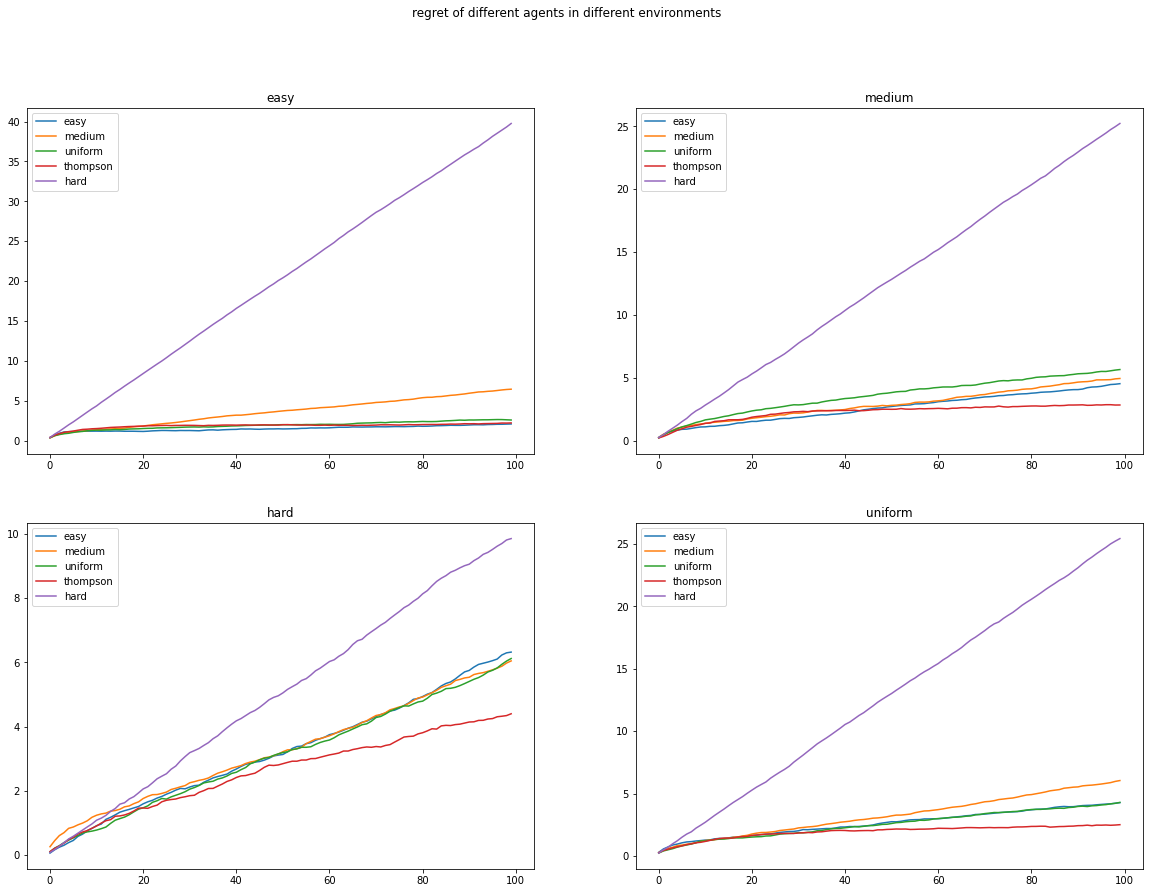

In [27]:
# plot regret of different bandits
# reg_df['uu'] = regret
reg_df = pd.read_csv('regret_bandits.csv')
# reg_df.to_csv('regret_bandits.csv')
plt.figure(figsize=(20, 14))
plt.suptitle('regret of different agents in different environments')
plt.subplot(221)
labels = ['easy', 'medium','uniform', 'thompson', 'hard']
for p in [reg_df[['ee','em', 'eu','eT', 'eh']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('easy')
plt.subplot(222)
for p in [reg_df[['me','mm','mu','mT', 'mh']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('medium')
plt.subplot(223)
for p in [reg_df[['he','hm','hu','hT', 'hh']]]:
    plt.plot(p);
plt.legend(labels);
plt.title('hard')
plt.subplot(224)
for p in [reg_df[['ue','um','uu', 'uT', 'uh']]]:
    plt.plot(p);
plt.legend(labels)
plt.title('uniform')
plt.savefig('regret of different agents in different environments w hard.png')


In [ ]:
reg_df.to_csv('regret_bandits.csv')
# b.episode

In [ ]:
class ManualBenchmark:
    def __init__(self, agent):
        self.agent = agent
    
    def play(self):
        agent.model.reset_states()
        action, reward, timestep, done = 0, 0, 1, 0
#         actions, rewards, values = [] * 3
        while reward >= 0:
            # action and reward at t - 1 and timestep at t
            action, value, _ = agent._predict(action, reward, timestep)
            reward = input(f"LSTM chose {action}, give me a reward 0 or 1 (-1 ends the game)")
            reward = int(reward)
            # rewards, values and actions at t
#             rewards.append(reward)
#             actions.append(action)
#             values.append(value)
            timestep += 1
        return actions, rewards, values

In [ ]:
mb = ManualBenchmark(agent)

In [ ]:
mb.play()

LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [0], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 1
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me a reward 0 or 1 (-1 ends the game) 0
LSTM chose [1], give me 

KeyboardInterrupt: Interrupted by user